In [17]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft
import math

#time-frequency analysis
#X is the time domain signal
#AWIN is an analysis window
#TIMESTEP is the # of samples between adjacent time windows.
#NUMFREQ is the # of frequency components per time point.
#
#TFMAT complex matrix time-freq representation

def tfanalysis(x,awin,timestep,numfreq):
    nsamp=x.size
    wlen=awin.size
    x=np.reshape(x,-1,'F')
    awin=np.reshape(awin,-1,'F') #make inputs go column-wise
    numtime=math.ceil((nsamp-wlen+1)/timestep)
    tfmat=np.zeros((numfreq,numtime+1))+0j
    sind=None
    for i in range(0,numtime):
        sind=((i)*timestep)
        tfmat[:,i]=fft(x[sind:(sind+wlen)]*awin,numfreq)
    i=i+1
    sind=((i)*timestep)
    lasts = min(sind,x.size-1)
    laste=min((sind+wlen),x.size-1)
    tfmat[:,-1]=fft(np.hstack((x[lasts:laste],np.zeros(wlen-(laste-lasts))))*awin,numfreq)
    return tfmat

In [18]:
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft
import numpy as np
import math

#time-frequency synthesis
#TIMEFREQMAT is the complex matrix time-freq representation
#SWIN is the synthesis window
#TIMESTEP is the # of samples between adjacent time windows.
#NUMFREQ is the # of frequency components per time point.
#
#X contains the reconstructed signal.

def tfsynthesis(timefreqmat,swin,timestep,numfreq):
	timefreqmat=np.asarray(timefreqmat)
	swin=np.reshape(swin,-1,'F')
	winlen=swin.size
	(numfreq, numtime)=timefreqmat.shape
	ind=np.fmod(np.array(range(0,winlen)),numfreq)
	x=np.zeros(((numtime-1)*timestep+winlen))
	for i in range(0,numtime):
		temp=numfreq*np.real(ifft(timefreqmat[:,i]))
		sind=((i)*timestep)
		for i in range(0,winlen):
			x[sind+i]=x[sind+i]+temp[ind[i]]*swin[i]
	return x	

In [19]:
import numpy as np
from scipy import ndimage
from scipy import signal
import math

# Smoothening for better identification of the peaks in a graph. Could have used Gaussian Kernels to do the same
# but it seemed better visual effects were given when this algorithm was followed ( Again, based on original CASA495)
#MAT is the 2D matrix to be smoothed.
#KER is either
#(1)a scalar
#(2)a matrix which is used as the averaging kernel.

def twoDsmooth(mat,ker):
    try:
        len(ker)
        kmat = ker
        
    except:
        kmat = np.ones((ker,ker))
        kmat = kmat / pow(ker, 2)

    [kr,kc] = list(kmat.shape)
    if (kr%2 == 0):
        conmat = np.ones((2,1))
        kmat = signal.convolve2d(kmat,conmat,'symm','same')
        kr = kr + 1

    if (kc%2 == 0):
        conmat = np.ones((2,1))
        kmat = signal.convolve2d(kmat,conmat,'symm','same')
        kc = kc + 1

    [mr,mc] = list(mat.shape)
    fkr = math.floor(kr/2)
    fkc = math.floor(kc/2)
    rota = np.rot90(kmat,2)
    mat=signal.convolve2d(mat,rota,'same','symm')
    return mat

fmat:  [[ 0.00613592  0.00613592  0.00613592 ...  0.00613592  0.00613592
   0.00613592]
 [ 0.01227185  0.01227185  0.01227185 ...  0.01227185  0.01227185
   0.01227185]
 [ 0.01840777  0.01840777  0.01840777 ...  0.01840777  0.01840777
   0.01840777]
 ...
 [-0.01840777 -0.01840777 -0.01840777 ... -0.01840777 -0.01840777
  -0.01840777]
 [-0.01227185 -0.01227185 -0.01227185 ... -0.01227185 -0.01227185
  -0.01227185]
 [-0.00613592 -0.00613592 -0.00613592 ... -0.00613592 -0.00613592
  -0.00613592]]


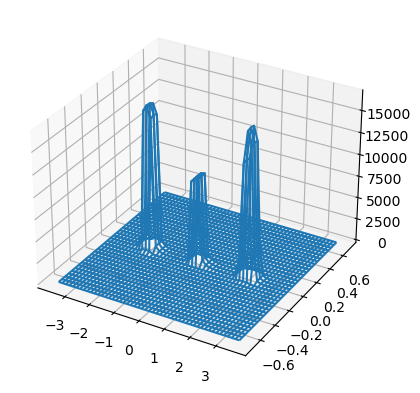

In [20]:
import numpy as np
from scipy.io.wavfile import read,write
import math
import numpy.ma as ma
# np.set_printoptions(threshold=np.nan)
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# from tfanalysis import tfanalysis
# from tfsynthesis import tfsynthesis
# from twoDsmooth import twoDsmooth

################################################
#     setp 1,2,3
################################################ 
# 1. analyze the signals - STFT
# 1) Create the spectrogram of the Left and Right channels.

#constants used
pi=3.14159265359    
eps=2.2204e-16
wlen=1024;
timestep=512;
numfreq=1024;


awin=np.hamming(wlen) #analysis window is a Hamming window Looks like Sine on [0,pi]
x1=read('dataset3/0.wav')
x2=read('dataset3/1.wav')

fs=x1[0] # Obtain sampling rate
x1=x1[1]
x2=x2[1]
x1=x1/np.iinfo(x1.dtype).max # Dividing by maximum to normalise
x2=x2/np.iinfo(x2.dtype).max # Dividing by maximum to normalise

tf1=tfanalysis(x1,awin,timestep,numfreq) #time-freq domain
tf2=tfanalysis(x2,awin,timestep,numfreq) #time-freq domain
x1=np.asmatrix(x1)
x2=np.asmatrix(x2)
tf1=np.asmatrix(tf1)
tf2=np.asmatrix(tf2)

#removing DC component
tf1=tf1[1:,:]
tf2=tf2[1:,:]
#eps is the a small constant to avoid dividing by zero frequency in the delay estimation

#calculate pos/neg frequencies for later use in delay calc ??

a=np.arange(1,((numfreq/2)+1))
b=np.arange((-(numfreq/2)+1),0)
freq=(np.concatenate((a,b)))*((2*pi)/numfreq) #freq looks like saw signal

a=np.ones((tf1.shape[1],freq.shape[0]))
freq=np.asmatrix(freq)
a=np.asmatrix(a)
for i in range(a.shape[0]):
    a[i]=np.multiply(a[i],freq)
fmat=a.transpose()

####################################################

#2.calculate alpha and delta for each t-f point
#2) For each time/frequency compare the phase and amplitude of the left and
#   right channels. This gives two new coordinates, instead of time-frequency 
#   it is phase-amplitude differences.

R21 = (tf2+eps)/(tf1+eps)
#2.1HERE WE ESTIMATE THE RELATIVE ATTENUATION (alpha)
a=np.absolute(R21) #relative attenuation between the two mixtures
alpha=a-1./a #'alpha' (symmetric attenuation)
#2.2HERE WE ESTIMATE THE RELATIVE DELAY (delta)
delta = -(np.imag((np.log(R21)/fmat)))

print("fmat: ", fmat)
# imaginary part, 'delta' relative delay
####################################################

# 3.calculate weighted histogram
# 3) Build a 2-d histogram (one dimension is phase, one is amplitude) where 
#    the height at any phase/amplitude is the count of time-frequency bins that
#    have approximately that phase/amplitude.

p=1; q=0;
h1=np.power(np.multiply(np.absolute(tf1),np.absolute(tf2)),p) #refer to run_duet.m line 45 for this. It's just the python translation of matlab 
h2=np.power(np.absolute(fmat),q)

tfweight=np.multiply(h1,h2) #weights vector 
maxa=0.7;
maxd=3.6;#histogram boundaries for alpha, delta

abins=35;
dbins=50;#number of hist bins for alpha, delta


# only consider time-freq points yielding estimates in bounds
amask=(abs(alpha)<maxa)&(abs(delta)<maxd)
amask=np.logical_not(amask)
alphavec = np.asarray(ma.masked_array(alpha, mask=(amask)).transpose().compressed())[0]
deltavec = np.asarray(ma.masked_array(delta, mask=(amask)).transpose().compressed())[0]
tfweight = np.asarray(ma.masked_array(tfweight, mask=(amask)).transpose().compressed())[0]
# to do masking the same way it is done in Matlab/Octave, after applying a mask we must take transpose and compress

#determine histogram indices (sampled indices?)

alphaind=np.around((abins-1)*(alphavec+maxa)/(2*maxa))
deltaind=np.around((dbins-1)*(deltavec+maxd)/(2*maxd))

#FULL-SPARSE TRICK TO CREATE 2D WEIGHTED HISTOGRAM
#A(alphaind(k),deltaind(k)) = tfweight(k), S is abins-by-dbins
A=sp.sparse.csr_matrix((tfweight, (alphaind, deltaind)),shape=(abins,dbins)).todense()
#smooththehistogram-localaverage3-by-3neighboringbins

A=twoDsmooth(A,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X=np.linspace(-maxd,maxd,dbins)
Y=np.linspace(-maxa,maxa,abins)
X, Y = np.meshgrid(X, Y)
ax.plot_wireframe(X,Y,A)
plt.show()

# You can have a look at the histogram to look at the local peaks and what not

######################################    step 4,5,6,7
######################################
#4.peak centers (determined from histogram) THIS IS DONE BY HUMAN.
#4) Determine how many peaks there are in the histogram.
#5) Find the location of each peak. 

numsources=3;

# peak estimates provided in source code
peakdelta=np.matrix([-2, -2, 0, 2, 2]);
peakalpha=np.matrix([.19, -.21, 0, .19, -.21]);

# my own peak estimates. I'm not sure the ones provided are correct.
peakdelta=np.array([-1.4, .66, 1.25, 1.9, .51]);
peakalpha=np.array([.4, -.29, .12, .66, -.5]);

#convert alpha to a

peaka=(peakalpha+np.sqrt(np.square(peakalpha)+4))/2;
peaka=np.asarray(peaka)

##################################################
#5.determine masks for separation
#6) Assign each time-frequency frame to the nearest peak in phase/amplitude 
#  space. This partitions the spectrogram into sources (one peak per source)

test = float("inf")
bestsofar=test*np.ones(tf1.shape)
bestind=np.zeros(tf1.shape)

for i in range(peakalpha.size):
	score = np.power(abs(np.multiply(peaka[i]*np.exp(-1j*fmat*peakdelta[i]),tf1)-tf2),2)/(1+peaka[i]*peaka[i])
	mask=score<bestsofar
	np.place(bestind,mask,i+1)
	s_mask=np.asarray(ma.masked_array(score, mask=np.logical_not(mask)).compressed())[0]
	np.place(bestsofar,mask,s_mask)

###################################################
#6.&7.demix with ML alignment and convert to time domain
#7) Then you create a binary mask (1 for each time-frequency point belonging to my source, 0 for all other points)
#8) Mask the spectrogram with the mask created in step 7.
#9) Rebuild the original wave file from 8.
#10) Listen to the result.

est=np.zeros((numsources,x1.shape[1]))
(row,col)=bestind.shape
for i in range(0,numsources):
	mask=ma.masked_equal(bestind,i+1).mask
	# here, 'h' stands for helper; we're using helper variables to break down the logic of
	# what's going on. Apologies for the order of the 'h's
	h1=np.zeros((1,tf1.shape[1]))
	h3=np.multiply((peaka[i]*np.exp(1j*fmat*peakdelta[i])),tf2)
	h4=((tf1+h3)/(1+peaka[i]*peaka[i]))
	h2=np.multiply(h4,mask)
	h=np.concatenate((h1,h2))

	esti=tfsynthesis(h,math.sqrt(2)*awin/1024,timestep,numfreq)

	#add back into the demix a little bit of the mixture
    #as that eliminates most of the masking artifacts

	est[i]=esti[0:x1.shape[1]]
	write('out'+str(i),fs,np.asarray(est[i]+0.05*x1)[0])
	
    # to ensure .wav files are playable the output is first converted to a numpy int16 array, before being written to a .wav file
    # output = np.int16(output)
	write("temp"+str(i)+".wav", fs, np.asarray(est[i]+0.05*x1)[0])

/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_6938/3571355731.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(range(tf1.shape[1]), range(tf1.shape[0]), np.log(np.abs(tf1)))
/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_6938/3571355731.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(range(tf1.shape[1]), range(tf1.shape[0]), np.log(np.abs(tf1)))


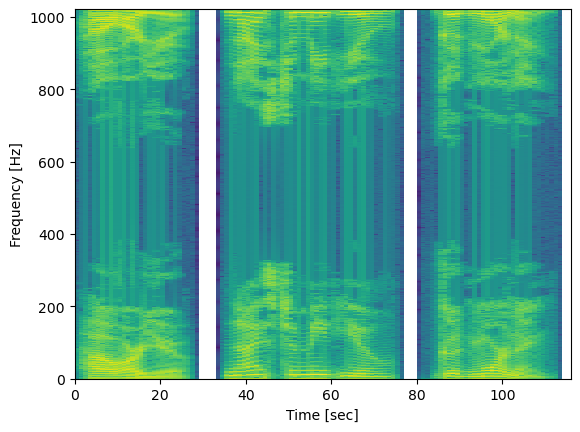

In [21]:
# Plot Spectrogram tf1
plt.pcolormesh(range(tf1.shape[1]), range(tf1.shape[0]), np.log(np.abs(tf1)))

# plot spec delta
# plt.pcolormesh(range(delta.shape[1]), range(delta.shape[0]), np.log(np.abs(delta)))

# plt.pcolormesh(t1, f1, np.log(np.abs(delta_phi)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_6938/231448453.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(range(delta.shape[1]), range(delta.shape[0]), np.log(np.abs(delta)))
/var/folders/vr/dw_gb9lj03d7lh7m2nnvl_jc0000gn/T/ipykernel_6938/231448453.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(range(delta.shape[1]), range(delta.shape[0]), np.log(np.abs(delta)))


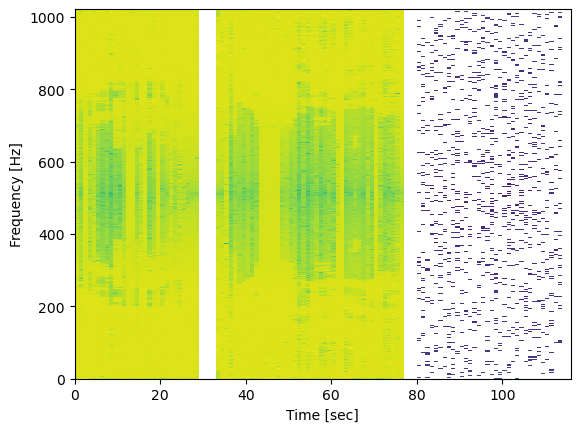

In [22]:
# Plot Spectrogram Delta Phi
plt.pcolormesh(range(delta.shape[1]), range(delta.shape[0]), np.log(np.abs(delta)))

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()